Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [ ]:
NAME = "Iga Miller"

---

# 2. Wielomodalne autokodery

Przejdziemy teraz do implementacji modelu **wielomodalnego autokodera**. W przypadku rozważanych przez nas danych, autokoder ten będzie posiadać dwa wejścia oraz dwa wyjścia (wcześniej wyznaczone wektory cech obrazków oraz tekstów).

In [1]:
from typing import Dict, List, Type

import pandas as pd
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.nn import functional as F

from src.dataset import DataModule
from src.downstream import evaluate_classification
from src.nn.unimodal import UnimodalAE
from src.train import extract_embeddings, train_model
from src.visualization import make_interactive_scatter_plot, visualize_most_similar

## Zadanie 2.1 (2 pkt)
Zaczniemy od implementacji modułu kodera wielomodalnego. Należy uzupełnić poniższą implementację w taki sposób, aby:
- dla każdej modalności (określonej przez parametr `modality_names`) został utworzony modal perceptrona wielowarstwowego (MLP), który będzie przekształcać cechy w danej modalności (pamiętaj aby odpowiednio przypisać moduły PyTorchowe – np. `ModuleList` albo `ModuleDict`)
- MLP dla każdej modalności będzie posiadać taką samą architekturę (z wyłączeniem wymiaru wejściwego) - wykorzystaj podane w konstruktorze parametry dla tych sieci MLP:
  * `in_dims` - wymiary danych wejściowych dla każdej modalności,
  * `hidden_dims` - rozmiary warstw ukrytych, takie same dla każdego MLP,
  * `out_dim` - wyjściowy rozmiar, również takie same dla każdego MLP.
- w metodzie `forward()` przekształć odpowiednie modalności przez przypisane do nich sieci MLP, na wyjściu zwróć listę wektorów

In [2]:
from torch.nn import ModuleDict

class MultimodalEncoder(nn.Module):

    def __init__(
        self,
        modality_names: List[str],
        in_dims: Dict[str, int],
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
    ):
        super().__init__()

        self.modality_names = modality_names
        
        # TU WPISZ KOD
        self.mlp = nn.ModuleDict()

        for modality in modality_names:
            layers = []
            for i in range(len(hidden_dims)):
                if i == 0:
                    layers.append(nn.Linear(in_dims[modality], hidden_dims[i]))
                else:
                    layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(hidden_dims[-1], out_dim))
            layers.append(last_activation())

            self.mlp[modality] = nn.ModuleList(layers)
    
    def forward(self, x: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        # TU WPISZ KOD
        encoded_modalities = []
        for modality in self.modality_names:
            encoder_layers = self.mlp[modality]
            encoded_modality = x[modality]
            for layer in encoder_layers:
                encoded_modality = layer(encoded_modality)
            encoded_modalities.append(encoded_modality)
        return encoded_modalities
        
    @staticmethod
    def from_hparams(hparams):
        return MultimodalEncoder(
            modality_names=hparams["modality_names"],
            in_dims=hparams["data_dims"],
            hidden_dims=hparams["hidden_dims"],
            out_dim=hparams["emb_dim"],
            last_activation=nn.Tanh,
        )



## Zadanie 2.2 (2 pkt)
Zaimplementuj dwie strategie łączenia wektorów ukrytych z różnych modalności w jeden wielomodalny wektor reprezentacji:
- w klasie `AvgFusion` zaimplementuj uśrednianie wektorów z różnych modalności
- w klasie `MLPFusion` skonkatenuj wektory z różnych modalności a następnie przekształć wynik przez sieć MLP (parametry sieci podane w konstruktorze)

In [3]:
class AvgFusion(nn.Module):
    
    def forward(self, h: List[torch.Tensor]) -> torch.Tensor:
        # TU WPISZ KOD
        combined = torch.stack(h, dim=0)
        fused = torch.mean(combined, dim=0)
        return fused
    
    
class MLPFusion(nn.Module):
    
    def __init__(
        self,
        modality_dim: int,
        num_modalities: int,
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
    ):
        super().__init__()
        
        # TU WPISZ KOD
        self.num_modalities = num_modalities
        self.mlp = nn.ModuleList()

        input_dim = modality_dim * num_modalities
        for i, hidden_dim in enumerate(hidden_dims):
            self.mlp.append(nn.Linear(input_dim, hidden_dim))
            self.mlp.append(nn.ReLU())
            input_dim = hidden_dim

        self.mlp.append(nn.Linear(input_dim, out_dim))
        self.mlp.append(last_activation())
        
    def forward(self, h: List[torch.Tensor]) -> torch.Tensor:
        # TU WPISZ KOD
        fused = torch.cat(h, dim=1)
        fused = fused.view(-1, self.num_modalities * h[0].size(1))
        for layer in self.mlp:
            fused = layer(fused)
        return fused

## Zadanie 2.3 (2 pkt)
Analogicznie do kodera wielomodalnego, musimy zaimplementować moduł wielomodalnego dekodera.
- dla każdej modalności utwórz sieć MLP, która będzie dekodować (rekonstruować) oryginalne atrybuty obiektu w danej modalności:
  * `in_dim` określa wymiar wejściowego wielomodalnego wektora reprezentacji (wspólne dla wszystkich modalności)
  * `hidden_dims` określa rozmiary warstw ukrytych modeli MLP (wspólne dla wszystkich modalności)
  * `out_dims` określa wymiary atrybutów (które chcemy zrekonstruować) w każdej modalności
- w metodzie `forward()` zastosuj utworzone sieci MLP na wielomodalnej reprezentacji `z` i zwróć słownik, w którym klucze określają nazwy modalności a skojarzone wartości to rekonstrukcje atrybutów w danej modalności

In [4]:
class MultimodalDecoder(nn.Module):

    def __init__(
        self,
        modality_names: List[str],
        in_dim: int,
        hidden_dims: List[int],
        out_dims: Dict[str, int],
        last_activation: Type[nn.Module],
    ):
        super().__init__()

        self.modality_names = modality_names
        
        # TU WPISZ KOD
        self.decoders = nn.ModuleDict()

        for modality in modality_names:
            layers = []
            for i in range(len(hidden_dims)):
                if i == 0:
                    layers.append(nn.Linear(in_dim, hidden_dims[i]))
                else:
                    layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(hidden_dims[-1], out_dims[modality]))
            layers.append(last_activation())

            self.decoders[modality] = nn.Sequential(*layers)

    def forward(self, z: torch.Tensor) -> Dict[str, torch.Tensor]:
        # TU WPISZ KOD
        reconstructions = {}

        for modality in self.modality_names:
            decoder = self.decoders[modality]
            reconstruction = decoder(z)
            reconstructions[modality] = reconstruction

        return reconstructions

## Zadanie 2.4 (2 pkt)
Przeanalizuj implementację klasy bazowej `BaseAE` a następnie dokończ implementację właściwego wielomodalnego autokodera:
- w metodzie `forward()` zastosuj wielomodalny koder `encoder` na podanych danych wejściowych, a następnie połącz listę ukrytych wektorów w jedną wielomodalną reprezentację, wykorzystując moduł fuzji `fusion`
- w metodzie `_common_step()` zaimplementuj krok uczenia autokodera:
  * wyznacz wielomodalną reprezentację `z`
  * przeprowadź rekonstrukcję oryginalnych cech `x_rec` na podstawie reprezentacji `z`
  * oblicz funkcję kosztu jako błąd średniokwadratowy (`MSE`) po każdej modalności, a wartości tych funkcji kosztu uśrednij względem wszystkich modalności

In [5]:
from src.nn.ae import BaseAE


class MultimodalAE(BaseAE):

    def __init__(self, hparams):
        encoder_cls = hparams["encoder_cls"]
        
        super().__init__(
            hparams=hparams,
            encoder=encoder_cls.from_hparams(hparams),
            decoder=MultimodalDecoder(
                modality_names=hparams["modality_names"],
                in_dim=hparams["emb_dim"],
                hidden_dims=hparams["hidden_dims"][::-1],
                out_dims=hparams["data_dims"],
                last_activation=nn.Identity,
            ),
        )
        
        if hparams["fusion"] == "Avg":
            self.fusion = AvgFusion()
        elif hparams["fusion"] == "MLP":
            self.fusion = MLPFusion(
                modality_dim=hparams["emb_dim"],
                num_modalities=len(hparams["modality_names"]),
                hidden_dims=[hparams["emb_dim"], hparams["emb_dim"]],
                out_dim=hparams["emb_dim"],
                last_activation=nn.Tanh,
            )
        else:
            raise ValueError(f"Unknown fusion module: \"{hparams['fusion']}\"")

    def forward(self, batch) -> torch.Tensor:
        # TU WPISZ KOD
        z = self.encoder(batch)
        fused_z = self.fusion(z)
        return fused_z

    def _common_step(self, batch) -> torch.Tensor:
        # TU WPISZ KOD
        z = self.forward(batch)
    
        x_rec = self.decoder(z)
        
        recon_loss = 0
        for modality in self.decoder.modality_names:
            recon_loss += nn.MSELoss()(x_rec[modality], batch[modality])
        recon_loss /= len(self.decoder.modality_names)
        
        return recon_loss



In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

In [6]:
default_hparams = {
    "encoder_cls": MultimodalEncoder,
    "modality_names": ["img_emb", "text_emb"],
    "data_dims": {"img_emb": 2048, "text_emb": 384}, 
    "batch_size": 64,
    "num_epochs": 30,
    "hidden_dims": [256, 256, 256],
    "emb_dim": 128,
    "lr": 1e-3,
    "weight_decay": 5e-4,
}

In [7]:
datamodule = DataModule(batch_size=default_hparams["batch_size"])

In [72]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "ImageTextAvgAE",
        "fusion": "Avg",
        **default_hparams,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\ImageTextAvgAE

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [74]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "ImageTextMLPAE",
        "fusion": "MLP",
        **default_hparams,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\ImageTextMLPAE

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | MLPFusion         | 65.9 K
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.889     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [75]:
multimodal_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="ImageTextAvgAE",
    datamodule=datamodule,
)

multimodal_mlp_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="ImageTextMLPAE",
    datamodule=datamodule,
)


In [88]:
make_interactive_scatter_plot(
    title="Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(multimodal_avg_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



In [87]:
make_interactive_scatter_plot(
    title="Multimodal embeddings (MLP)",
    z_2d=PCA(n_components=2).fit_transform(multimodal_mlp_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



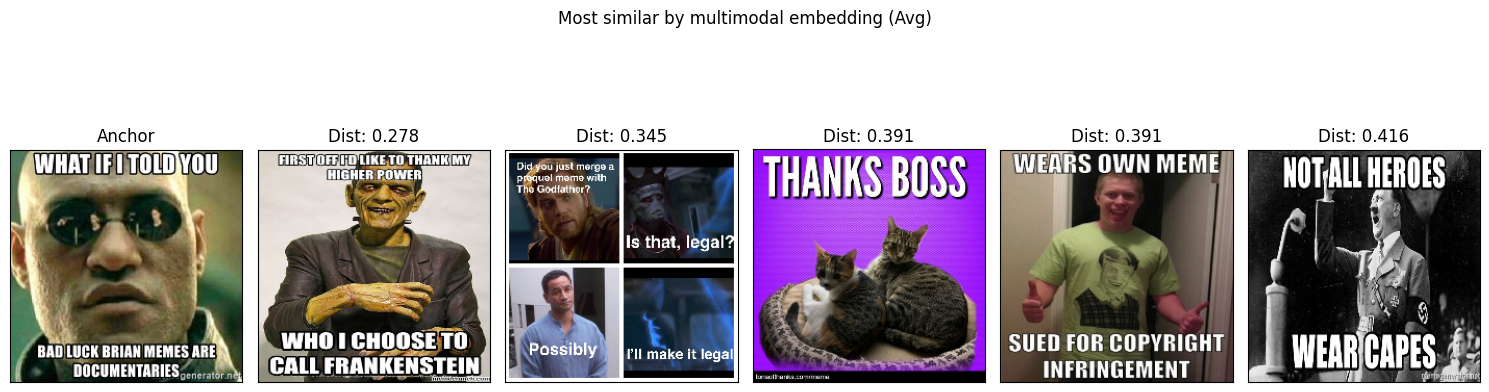

In [76]:
_ = visualize_most_similar(
    title="Most similar by multimodal embedding (Avg)",
    anchor_index=339,
    z=multimodal_avg_emb,
    df=datamodule.df["all"],
)

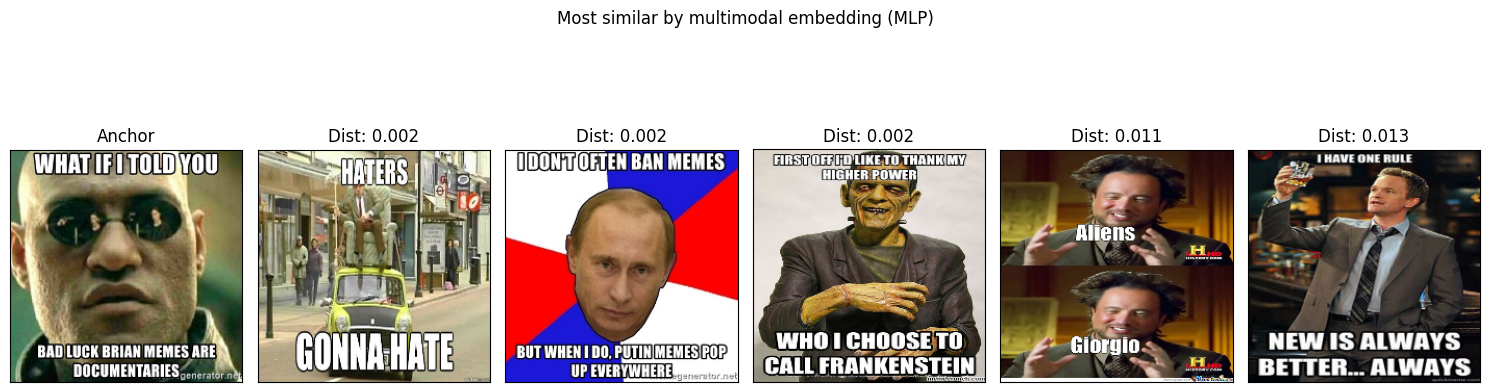

In [77]:
_ = visualize_most_similar(
    title="Most similar by multimodal embedding (MLP)",
    anchor_index=339,
    z=multimodal_mlp_emb,
    df=datamodule.df["all"],
)

In [80]:
evaluate_classification(
    model_names=[
        (UnimodalAE, "ImageAE"), 
        (UnimodalAE, "TextAE"), 
        (MultimodalAE, "ImageTextAvgAE"),
        (MultimodalAE, "ImageTextMLPAE"),
    ],
    datamodule=datamodule,
)

train_AUC                                                 
task               humour motivational  offensive    sarcasm  sentiment   
model                                                                     
ImageAE         56.41 [%]    55.66 [%]  53.66 [%]  56.28 [%]  55.46 [%]  \
TextAE          59.74 [%]    57.38 [%]  62.70 [%]  62.36 [%]  62.15 [%]   
ImageTextAvgAE  56.64 [%]    57.21 [%]  59.62 [%]  60.78 [%]  59.73 [%]   
ImageTextMLPAE  53.15 [%]    51.70 [%]  54.33 [%]  51.93 [%]  52.72 [%]   

                 test_AUC                                                
task               humour motivational  offensive    sarcasm  sentiment  
model                                                                    
ImageAE         50.39 [%]    50.93 [%]  50.41 [%]  49.09 [%]  48.00 [%]  
TextAE          50.07 [%]    43.54 [%]  53.12 [%]  53.56 [%]  47.14 [%]  
ImageTextAvgAE  50.73 [%]    49.41 [%]  54.73 [%]  52.46 [%]  49.96 [%]  
ImageTextMLPAE  52.86 [%]    53.22 [%]  50.85 [%]  52.03 [%]  44.05 [%]

# Maskowane uczenie
Dotychczas wielomodalny autokoder był uczony w taki sposób, że zarówno na wejściu jak i na wyjściu otrzymywał informacje o obrazku, jak i tekście. Teraz zobaczymy jak model się będzie zachowywać w sytuacji, kiedy jedna z modalności będzie **maskowana na wejściu** (można w ten sposób symulować sytuacje, gdy jedna z modalności nie jest dostępna – *brakująca wartość*). 

Zaczniemy od przygotowania nowej implementacji `MultimodalEncoder`.

## Zadanie 2.5 (2 pkt)
Uzupełnij poniższą implementację klasy `MaskedMultimodalEncoder`, która będzie maskować cechy z wybranej modalności z określonym prawdopodobieństwem `p_m`:

- poprzez maskowanie danej modalności rozumiemy zastąpienie wektora cech w tej modalności dla konkretnego obiektu, wektorem składającym się z samych zer
- to czy pojedynczy obiekt będzie poddawany maskowaniu określamy na podstawie prawdopodobieństwa $p_m \in [0, 1]$
- zakładamy, że maskowanie dotyczy tylko etapu uczenia, natomiast w trakcie inferencji używamy dostępnych cech bez jakiejkolwiek modyfikacji

In [8]:
class MaskedMultimodalEncoder(nn.Module):

    def __init__(
        self,
        modality_names: List[str],
        in_dims: Dict[str, int],
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
        masked_modality: str,
        p_m: float,
    ):
        super().__init__()

        self.modality_names = modality_names
        self.modalities = nn.ModuleDict()
        self.masked_modality = masked_modality
        self.p_m = p_m

        for name in modality_names:
            modality_layers = []
            input_dim = in_dims[name]
            for hidden_dim in hidden_dims:
                modality_layers.append(nn.Linear(input_dim, hidden_dim))
                modality_layers.append(nn.ReLU())
                input_dim = hidden_dim

            modality_layers.append(nn.Linear(input_dim, out_dim))
            modality_layers.append(last_activation())
            self.modalities[name] = nn.Sequential(*modality_layers)

    def forward(self, x: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        embeddings = []
        for name, modality in self.modalities.items():
            if self.training and name == self.masked_modality and torch.rand(1).item() < self.p_m:
                # mask the input to the current modality during training with probability p_m
                embeddings.append(modality(torch.zeros_like(x[name])))
            else:
                embeddings.append(modality(x[name]))
        return embeddings
        
    @staticmethod
    def from_hparams(hparams):
        return MaskedMultimodalEncoder(
            modality_names=hparams["modality_names"],
            in_dims=hparams["data_dims"],
            hidden_dims=hparams["hidden_dims"],
            out_dim=hparams["emb_dim"],
            last_activation=nn.Tanh,
            masked_modality=hparams["masked_modality"],
            p_m=hparams["p_m"],
        )

In [9]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedImage_ImageTextAvgAE",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "img_emb",
        "p_m": 1.0,
    },
    datamodule=datamodule,
)

train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedText_ImageTextAvgAE",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "text_emb",
        "p_m": 1.0,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory C:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Reprezentacja_wiedzy\l06-czw-15-Iga-Miller\data\checkpoints\MaskedImage_ImageTextAvgAE exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
c:\User

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory C:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Reprezentacja_wiedzy\l06-czw-15-Iga-Miller\data\checkpoints\MaskedText_ImageTextAvgAE exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625    

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [83]:
masked_image_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="MaskedImage_ImageTextAvgAE",
    datamodule=datamodule,
)

masked_text_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="MaskedText_ImageTextAvgAE",
    datamodule=datamodule,
)


In [84]:
make_interactive_scatter_plot(
    title="Masked Image (p_m = 1.0) - Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(masked_image_avg_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



In [85]:
make_interactive_scatter_plot(
    title="Masked Text (p_m = 1.0) - Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(masked_text_avg_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



In [86]:
evaluate_classification(
    model_names=[
        (UnimodalAE, "ImageAE"), 
        (UnimodalAE, "TextAE"), 
        (MultimodalAE, "ImageTextAvgAE"),
        (MultimodalAE, "ImageTextMLPAE"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE"),
    ],
    datamodule=datamodule,
)

train_AUC                                      
task                           humour motivational  offensive    sarcasm   
model                                                                      
ImageAE                     56.41 [%]    55.66 [%]  53.66 [%]  56.28 [%]  \
TextAE                      59.74 [%]    57.38 [%]  62.70 [%]  62.36 [%]   
ImageTextAvgAE              56.64 [%]    57.21 [%]  59.62 [%]  60.78 [%]   
ImageTextMLPAE              53.15 [%]    51.70 [%]  54.33 [%]  51.93 [%]   
MaskedImage_ImageTextAvgAE  56.94 [%]    57.80 [%]  59.57 [%]  60.38 [%]   
MaskedText_ImageTextAvgAE   64.89 [%]    63.01 [%]  68.47 [%]  62.63 [%]   

                                        test_AUC                           
task                        sentiment     humour motivational  offensive   
model                                                                      
ImageAE                     55.46 [%]  50.39 [%]    50.93 [%]  50.41 [%]  \
TextAE                      62.15 [%]  50.07 [%]    43.54 [%]  53.12 [%]   
ImageTextAvgAE              59.73 [%]  50.73 [%]    49.41 [%]  54.73 [%]   
ImageTextMLPAE              52.72 [%]  52.86 [%]    53.22 [%]  50.85 [%]   
MaskedImage_ImageTextAvgAE  60.25 [%]  49.66 [%]    48.16 [%]  55.41 [%]   
MaskedText_ImageTextAvgAE   66.28 [%]  47.15 [%]    48.50 [%]  50.25 [%]   

                                                  
task                          sarcasm  sentiment  
model                                             
ImageAE                     49.09 [%]  48.00 [%]  
TextAE                      53.56 [%]  47.14 [%]  
ImageTextAvgAE              52.46 [%]  49.96 [%]  
ImageTextMLPAE              52.03 [%]  44.05 [%]  
MaskedImage_ImageTextAvgAE  52.90 [%]  46.73 [%]  
MaskedText_ImageTextAvgAE   53.87 [%]  46.98 [%]

## Zadanie 2.6 (2 pkt)
Zbadaj jak wartość parametru `p_m` wpływa na jakość otrzymywanych multimodalnych wektorów reprezentacji? (Skrajne wartości `p_m = 0` oraz `p_m = 1` zbadaliśmy w poprzednich przykładach). Skomentuj otrzymane wyniki.

In [12]:
def check_masking_probability_performance():
    p_m_values = [0.2, 0.5, 0.6, 0.9]

    for p_m in p_m_values:
        train_model(
        model_cls=MultimodalAE,
        hparams={
        **default_hparams,
        "name": f"MaskedImage_ImageTextAvgAE{p_m}",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "img_emb",
        "p_m": p_m,
        },
        datamodule=datamodule,
        )

        train_model(
        model_cls=MultimodalAE,
        hparams={
        **default_hparams,
        "name": f"MaskedText_ImageTextAvgAE{p_m}",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "text_emb",
        "p_m": p_m,
        },
        datamodule=datamodule,
        )

check_masking_probability_performance()


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory C:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Reprezentacja_wiedzy\l06-czw-15-Iga-Miller\data\checkpoints\MaskedImage_ImageTextAvgAE0.2 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
c:\U

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedText_ImageTextAvgAE0.2

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedImage_ImageTextAvgAE0.5

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedText_ImageTextAvgAE0.5

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedImage_ImageTextAvgAE0.6

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedText_ImageTextAvgAE0.6

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedImage_ImageTextAvgAE0.8

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedText_ImageTextAvgAE0.8

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedImage_ImageTextAvgAE0.9

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs\MaskedText_ImageTextAvgAE0.9

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [13]:
evaluate_classification(
    model_names=[
        (MultimodalAE, "MaskedImage_ImageTextAvgAE0.2"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE0.2"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE0.5"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE0.5"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE0.6"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE0.6"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE0.8"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE0.8"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE0.9"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE0.9"),
    ],
    datamodule=datamodule,
)

train_AUC                                      
task                              humour motivational  offensive    sarcasm   
model                                                                         
MaskedImage_ImageTextAvgAE0.2  56.79 [%]    58.03 [%]  58.99 [%]  59.88 [%]  \
MaskedText_ImageTextAvgAE0.2   55.95 [%]    55.27 [%]  59.23 [%]  59.57 [%]   
MaskedImage_ImageTextAvgAE0.5  56.94 [%]    57.34 [%]  59.80 [%]  60.35 [%]   
MaskedText_ImageTextAvgAE0.5   55.42 [%]    53.31 [%]  57.85 [%]  56.66 [%]   
MaskedImage_ImageTextAvgAE0.6  56.36 [%]    57.40 [%]  58.95 [%]  60.12 [%]   
MaskedText_ImageTextAvgAE0.6   53.76 [%]    52.61 [%]  56.51 [%]  54.50 [%]   
MaskedImage_ImageTextAvgAE0.8  56.40 [%]    57.17 [%]  59.43 [%]  59.21 [%]   
MaskedText_ImageTextAvgAE0.8   52.73 [%]    51.34 [%]  54.95 [%]  53.65 [%]   
MaskedImage_ImageTextAvgAE0.9  56.66 [%]    58.17 [%]  59.92 [%]  60.13 [%]   
MaskedText_ImageTextAvgAE0.9   57.76 [%]    58.93 [%]  61.57 [%]  57.56 [%]   

                                           test_AUC                           
task                           sentiment     humour motivational  offensive   
model                                                                         
MaskedImage_ImageTextAvgAE0.2  59.77 [%]  49.94 [%]    48.25 [%]  54.90 [%]  \
MaskedText_ImageTextAvgAE0.2   60.16 [%]  49.82 [%]    47.55 [%]  55.11 [%]   
MaskedImage_ImageTextAvgAE0.5  60.65 [%]  49.53 [%]    48.23 [%]  55.52 [%]   
MaskedText_ImageTextAvgAE0.5   58.60 [%]  49.14 [%]    45.97 [%]  53.07 [%]   
MaskedImage_ImageTextAvgAE0.6  60.38 [%]  49.93 [%]    47.47 [%]  55.15 [%]   
MaskedText_ImageTextAvgAE0.6   56.19 [%]  48.86 [%]    47.28 [%]  52.52 [%]   
MaskedImage_ImageTextAvgAE0.8  59.89 [%]  50.56 [%]    46.82 [%]  55.35 [%]   
MaskedText_ImageTextAvgAE0.8   52.69 [%]  50.63 [%]    49.13 [%]  50.85 [%]   
MaskedImage_ImageTextAvgAE0.9  59.63 [%]  50.49 [%]    48.07 [%]  55.38 [%]   
MaskedText_ImageTextAvgAE0.9   63.90 [%]  51.68 [%]    45.79 [%]  51.68 [%]   

                                                     
task                             sarcasm  sentiment  
model                                                
MaskedImage_ImageTextAvgAE0.2  52.23 [%]  49.25 [%]  
MaskedText_ImageTextAvgAE0.2   53.12 [%]  48.00 [%]  
MaskedImage_ImageTextAvgAE0.5  52.78 [%]  50.33 [%]  
MaskedText_ImageTextAvgAE0.5   52.48 [%]  48.20 [%]  
MaskedImage_ImageTextAvgAE0.6  52.09 [%]  49.93 [%]  
MaskedText_ImageTextAvgAE0.6   51.66 [%]  46.46 [%]  
MaskedImage_ImageTextAvgAE0.8  52.29 [%]  49.64 [%]  
MaskedText_ImageTextAvgAE0.8   53.84 [%]  45.60 [%]  
MaskedImage_ImageTextAvgAE0.9  52.48 [%]  49.25 [%]  
MaskedText_ImageTextAvgAE0.9   54.01 [%]  46.55 [%]